In [49]:
# import matplotlib
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import dataFunc
import pandas as pd
import ast
import os
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import euclidean
import time
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from kneed import KneeLocator
import random

In [53]:
#read files and process
############################################################
#read data files from folder to dictionary of data frames

path = '../driving data/colt-all-atributes/4drivers/'
names = ['.csv']

dfAll = []
files = []
counter = 0
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            if '~' in file:
                continue
            df_temp = ''
            counter += 1
            name = file.split('-')[0]
            filepath = r + file
            df_temp = pd.read_csv(filepath, delimiter = ',', na_values='-')
            df_temp['driver'] = str(name)
#             print(name + ' ' + str(df_temp.shape) + ' ' + file)
#             print(filepath)
            print(df_temp.shape)
            dfAll.append(df_temp)
############################################################
#read columne list to select from file
col_list = list()
fileName = '/col_list-IG.txt'
with open(fileName) as f:
    for line in f:
        print(line.strip('\n'))
        col_list.append(line.strip('\n'))
############################################################
#clean from rows with column names
for i in range(len(dfAll)):
    dfAll[i] = dfAll[i][dfAll[i].iloc[:,0] != dfAll[i].columns[0]]

# removo non acii from column names
for i in range(len(dfAll)):
    dataFunc.remove_non_ascii_column(dfAll[i])

#select only columns from the list
for i in range(len(dfAll)):
    dfAll[i] = dfAll[i][(col_list)]

# replace infinity with 0
for i in range(len(dfAll)):
    dfAll[i] = dfAll[i].replace('∞',0).round(3)

#values to numeric except 'driver'
for i in range(len(dfAll)):
    dataFunc.convert_numeric(dfAll[i],)

#visualise_treshold
# dataFunc.visualise_treshold(dfAll)

#fill NaN values with 0
for i in range(len(dfAll)):
    dfAll[i] = dfAll[i].fillna(0)
    
#re index
for i in range(len(dfAll)):
    dfAll[i] = dfAll[i].reset_index(drop=True)


(943, 116)
(680, 164)
(715, 164)
(690, 164)
Speed_(OBD)(km/h)
Fuel_Trim_Bank_1_Long_Term(prc)
Throttle_Position(Manifold)(prc)
Engine_Load(prc)
O2_Volts_Bank_1_sensor_2(V)
Turbo_Boost_&_Vacuum_Gauge(bar)
Trip_Time(Since_journey_start)(s)
driver


In [54]:
#divide to smaller Data Frames
observations = 300
df_temp = []
for i in range(len(dfAll)):
    idx = len(dfAll[i].index)
    n = round(idx / observations , 0)
#     print(idx)
#     print(n)
    if n > 1:
        print(n)
        md = int(idx%n)
        print(md)
        if md != 0:
            for d in range(md):
                print('drop index ' + str(d))
                dfAll[i] = dfAll[i].drop(d)
        dfs = np.split(dfAll[i], n, axis=0)
        for j in range(len(dfs)):
            df_temp.append(dfs[j])
    else:
        df_temp.append(dfAll[i])
        
dfAll = df_temp

for ii in range(len(dfAll)):
    dfAll[ii] = dfAll[ii].reset_index(drop=True)
    print(dfAll[ii].shape)
        

3.0
1
drop index 0
2.0
0
2.0
0
2.0
0
(314, 8)
(314, 8)
(314, 8)
(340, 8)
(340, 8)
(357, 8)
(357, 8)
(345, 8)
(345, 8)


In [16]:
dfAll[4].head()

,Speed_(OBD)(km/h),Trip_Time(Since_journey_start)(s),driver
0,0,439,dima
1,0,441,dima
2,0,442,dima
3,0,444,dima
4,0,446,dima


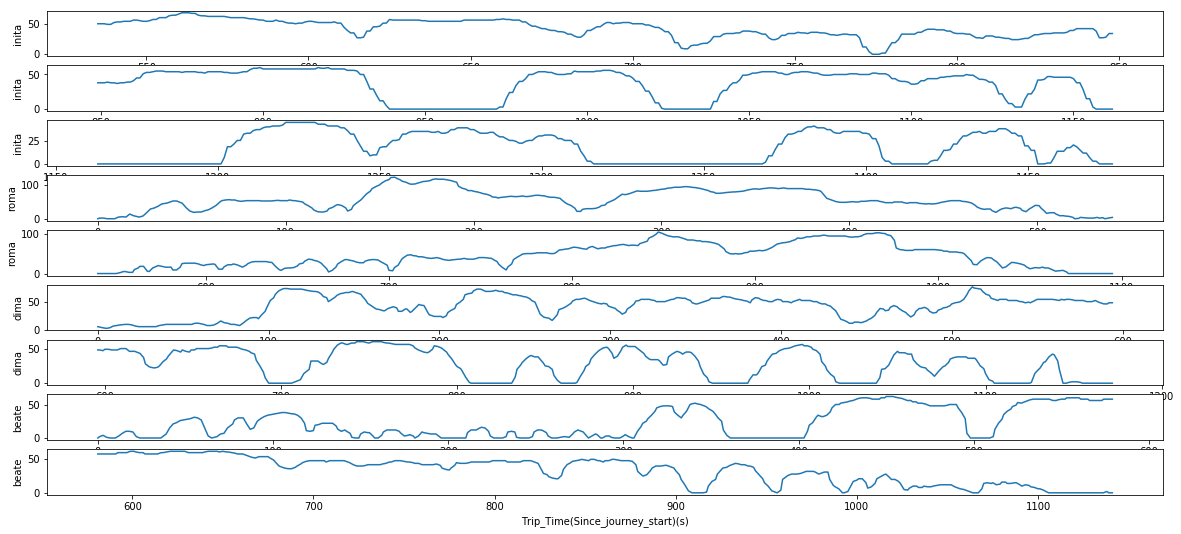

In [55]:
#visualise data
fig = plt.figure(figsize=(20,20))
for i in range(len(dfAll)):
    name = dfAll[i]['driver'][1]
    ax=plt.subplot(20,1,i+1)
    dfAll[i].plot(kind='line',y='Speed_(OBD)(km/h)',x='Trip_Time(Since_journey_start)(s)', ax=ax, legend=False).set_ylabel(name)
plt.show()

In [56]:

def extractUshapelets(df_dic, col_to_check, minSh = 5, maxSh = 20):
    tss = time.time()
    start_time = datetime.datetime.fromtimestamp(tss).strftime('%Y%m%d_%H:%M')
    print('Process started : ' + str(start_time))
    Sh_set = {}
    ts_dic = []
    for i in range(len(df_dic)):
        ts_dic.append(df_dic[i][col_to_check])
    
    start_index = random.randint(0,len(df_dic)-1)
    ts = ts_dic[start_index]
    run_cnt = 0
    
    print("Starting with index " + str(start_index))

    while True:
        run_cnt += 1
        temp_shapelet = []
        temp_gap = []
        temp_distance = []
        
        if run_cnt > len(df_dic)/2:
            break
        
        print("Run " + str(run_cnt) + ". " +str(len(ts_dic))+ " time series in Dataset.")
        for sl in range(minSh, maxSh) :
            for i in  range(len(ts.index) - sl):
                shaplet = ts[i:(i+sl)]
                if min(shaplet) == max(shaplet):
                    continue
                g, d = computeGap(shaplet, ts_dic)
                temp_shapelet.append(shaplet.tolist())
                temp_gap.append(g)
                temp_distance.append(d)

        if min(temp_gap) == max(temp_gap):
            i_gap = temp_gap[0]
            index1 = 0
            dt = temp_distance[0]
        else:
            index1 = temp_gap.index(max(temp_gap))
            i_gap = temp_gap[index1]
            dt = temp_distance[index1]
            
        print('gap : ' + str(i_gap))
        print('index : ' + str(index1))
        print('distance ' + str(dt))
        
        #if gap is 0 means that bad shapelet is chosen, move to searching for next.
        index2 = 0
        if i_gap == 0 :
            while True:
              index2 = random.randint(0,len(ts_dic)-1)
              if index2 != index1:
                break
            ts = ts_dic[index2]
            print('next index = ' +str(index2))
            continue

        Sh_set[run_cnt] = [i_gap, temp_shapelet[index1]]
        
        #get distance for best shapelet from TS
        dis = computeDistance(temp_shapelet[index1],ts_dic)
        print('best gap distances : '+ str(dis))
        print('marger dt distance : ' + str(dt))
        DA = {}
        for r in range(len(dis)):
            if dis[r] <= dt:
                DA[r] = dis[r]
        
        if len(DA) <= 1:
            print("Process ended after - if len(DA) <= 1:")
            break
            
        else:
            index2 = dis.index(max(dis))
            print('For next run, max distance time series index = ' + str(index2))
            ts = ts_dic[index2]
            DA_list=list(DA.values())
            treshold = np.mean(DA_list) + np.std(DA_list)
            

            for n in range(len(dis)-1,-1,-1):
                if dis[n] < treshold:
                    print( str(n) + '. Data set is dropped out after ' + str(run_cnt) + ' run.')
                    ts_dic.pop(n)
            
            
            if len(ts_dic) < 2 :
                print('process ended after - if len(ts_dic) < 2:')
                break
        
        
    
    tss = time.time()
    end_time = datetime.datetime.fromtimestamp(tss).strftime('%Y%m%d_%H:%M')
    print('Process ended : ' + str(end_time))
    return Sh_set

In [57]:
def computeGap(shapelet, dic):
    dis = computeDistance(shapelet, dic)
    dis = sorted(dis)
    
    maxGap = 0
    dt = 0
    
    for i in range(len(dis)-1):
        DB = list()
        DA = list()
        d = round((dis[i] + dis[i+1])/2 , 4)
        for j in range(len(dis)):
            if dis[j] < d:
                DA.append(dis[j])
            else:
                DB.append(dis[j])
        if len(DA) > 1 and len(DB) > 1:
            #find maximum gap 
            mA = np.mean(DA)
            mB = np.mean(DB)
            sdA = np.std(DA)
            sdB = np.std(DB)
            gap = round(mB - mA - sdA - sdB , 4)
    #             print('gap : ' + str(gap))
            if gap > maxGap:
                maxGap = gap
                dt = d
    
    return maxGap, dt

In [58]:
def computeDistance(shaplet, dic):
    dis = []
    sLen = len(shaplet)
    shaplet = np.nan_to_num(stats.zscore(shaplet))
    
    for i in range(len(dic)):
        dis.append(1000)
        ts = dic[i]
#         d = list()
        for j in range(len(ts)- sLen):
            z = ts[j:(j + sLen)]
            z = np.nan_to_num(stats.zscore(z))
            d = euclidean(z, shaplet)
            d = round(d,4)
#             d.append(euclidean(z, shaplet))
            if d < dis[i]:
                dis[i] = round((d / np.sqrt(sLen)),4)
#         print(dis[i])
    # add SQRT normalization to distances
    return dis

In [59]:
def clusterData(TS_dataSet, ShapletSet, numberOfClusters):
    #shaplet need to be arranged starting with the biggest gap. as the greedy search is implemented. 
    DIS = pd.DataFrame()
    
    cls_real = []
    for i in range(len(TS_dataSet)):
        cls_real.append(0)
    
    cls = {}
    Change_RI = {}
    sumDistanceList = []
    
    for l in range(len(ShapletSet)):
        shp = ShapletSet[l]
        dis = computeDistance(shp, TS_dataSet)
        DIS[l] = dis
        sumDIS = float("inf")
    
        #make coupe of iterations to find best kmeans prediction
        for s in range(10):
            kmeans = KMeans(n_clusters=numberOfClusters).fit(DIS)
            SUMD = kmeans.inertia_
            sumDistanceList.append(SUMD)
            if SUMD < sumDIS :
                sumDIS = SUMD
                cls[l] = kmeans.labels_
    
        if l == 0 :
            a = (adjusted_rand_score(cls[l], cls_real))
            Change_RI[l]=(1 - a)
        else:
            a = (adjusted_rand_score(cls[l], cls[l-1]))
            Change_RI[l]=(1 - a)
        
    maxIndex = max(Change_RI, key=Change_RI.get)
    clusterLabel = cls[maxIndex]
    SmD = sumDistanceList[maxIndex]
    
    
    return clusterLabel, SmD

In [60]:
def clusterDIS(TS_dataSet, ShapletSet1, numberOfClusters):
    #shaplet need to be arranged starting with the biggest gap. as the greedy search is implemented. 
    DIS = pd.DataFrame()
    
    #create map of vector distances for each shapelet
    for l in range(len(ShapletSet1)):
        shp = ShapletSet1[l]
        dis = computeDistance(shp, TS_dataSet)
        DIS[l] = dis
        sumDIS = float("inf")
    
    #make coupe of iterations to find best kmeans prediction
    for s in range(10):
        kmeans = KMeans(n_clusters=numberOfClusters).fit(DIS)
        SUMD = kmeans.inertia_
        if SUMD < sumDIS :
            sumDIS = SUMD
            cls = kmeans.labels_
          
    return cls,sumDIS

In [61]:
def create_classes(df):
    cls_actual = []
    for i in range(len(df)):
        cls_actual.append(dfAll[i]['driver'][0])

    cls_names = set(cls_actual)
    cls_names = list(cls_names)

    map_name = {}
    class_count = 0
    for name in cls_names:
        print(name + ' = ' + str(class_count))
        map_name[name] = class_count
        class_count += 1

    for i in range(len(cls_actual)):
        cls_actual[i] = map_name[cls_actual[i]]

#     print(cls_actual)
    return cls_actual


In [62]:
#find best K
# coding: utf-8
ShapletSet = extractUshapelets(dfAll,'Speed_(OBD)(km/h)',5,15)
print(ShapletSet)
os.system( "say U shapelet process has ended" )


#####################################################
# FIND CLUSTERS USING SHAPELETS AND DISTANCE VECOTRS

mmm = []

for key in ShapletSet:
    mmm.append(ShapletSet[key][1])


Kmin = 1
Kmax = int(round(len(dfAll) / 2,0)) + 1

tss = []
for i in range(len(dfAll)):
    tss.append(dfAll[i]['Speed_(OBD)(km/h)'])

CLS = []
SUMDIS = []
K = []

CLS_CRI = []
SUMDIS_CRI = []
K_CRI = []

for k in range(Kmin, Kmax):
    print(k)
    cls,sumDIS = clusterDIS(tss, mmm, k)
    K.append(k)
    CLS.append(cls)
    SUMDIS.append(sumDIS)
    
    cls2,sumDIS2 = clusterData(tss, mmm, k)
    K_CRI.append(k)
    CLS_CRI.append(cls2)
    SUMDIS_CRI.append(sumDIS2)    

#####################################################
# . PLOT AND FIND CLUSTERS

kn = KneeLocator(K, SUMDIS, curve='convex', direction='decreasing')
clusters = kn.knee

plt.plot(K, SUMDIS, 'bx-')
plt.xlabel('klasteru skaits')
plt.ylabel(u'Distanču kvadrātu summa')
plt.title(u'"Elkoņa" metode optimālam klasteru skaitam (visi shapeleti)')
plt.vlines(clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()


print('Klāsteri visi : ' + str(clusters))
print('Sadalījums visi : ' + str(CLS[K.index(clusters)]))

kn2 = KneeLocator(K, SUMDIS_CRI, curve='convex', direction='decreasing')
clusters_cri = kn2.knee

plt.plot(K, SUMDIS, 'bx-')
plt.xlabel('klasteru skaits')
plt.ylabel(u'Distanču kvadrātu summa')
plt.title(u'"Elkoņa" metode optimālam klasteru skaitam (CRI izvēlēti shapeleti)')
plt.vlines(clusters_cri, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()


print('Klāsteri CRI : ' + str(clusters_cri))
print('Sadalījums CRI : ' + str(CLS_CRI[K_CRI.index(clusters_cri)]))


#####################################################
# . ARI RESULTS

cls_true = create_classes(dfAll)
cls_all = CLS[K.index(clusters)]
cls_CRI = CLS_CRI[K_CRI.index(clusters_cri)]
print('Patiesais  : ' +'[' + str(' '.join(map(str, cls_true))) + ']')
print('cls_all : ' + str(cls_all))
print('All number of clusters : ' + str(clusters))
print('cls_CRI : ' + str(cls_CRI))
print('CRI number of clusters : ' + str(clusters_cri))

Rscore_all = round(adjusted_rand_score(cls_all, cls_true),3)
Rscore_CRI = round(adjusted_rand_score(cls_CRI, cls_true),3)
print('ARI visi : ' + str(Rscore_all))
print('ARI CRI : ' + str(Rscore_CRI))


Process started : 20190519_20:03
Starting with index 3
Run 1. 9 time series in Dataset.


KeyboardInterrupt: 